In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

In [2]:
from plot_utils import cool_savefig

In [3]:
small_batches_densities = np.zeros((1500*500))
medium_batches_densities = np.zeros((30*500))
large_batches_densities = np.zeros((500))

In [4]:
from glob import glob

filenames = sorted(list(glob('concentration_ML_estimates/*.density.npz')))
len(filenames)

500

In [5]:
for sim_num in range(500):
    npzfile = np.load(filenames[sim_num])
    
    small_batches_densities[sim_num*1500:(sim_num+1)*1500] = npzfile['small_batches']
    medium_batches_densities[sim_num*30:(sim_num+1)*30] = npzfile['medium_batches']
    large_batches_densities[sim_num] = npzfile['whole_sim']

In [6]:
print(np.mean(small_batches_densities < np.inf))
print(np.mean(medium_batches_densities < np.inf))
print(np.mean(large_batches_densities < np.inf))

0.4949653333333333
0.5013333333333333
0.506


a priori we know that estimates less than $0$ (which then were "manually" changed to $0$) are junk caused by `fsolve` being dumb -- so let's try to gauge what percentage of the data is affected by this problem

In [7]:
print(np.mean(small_batches_densities > 0))
print(np.mean(medium_batches_densities > 0))
print(np.mean(large_batches_densities > 0))

1.0
1.0
1.0


In [8]:
small_batches_densities = small_batches_densities[small_batches_densities > 0]
medium_batches_densities = medium_batches_densities[medium_batches_densities > 0]
large_batches_densities = large_batches_densities[large_batches_densities > 0]

In [9]:
def small_part(array, x): return array[array < x]
def finite_part(array): return small_part(array, np.inf)

In [10]:
from statsmodels.distributions.empirical_distribution import ECDF

In [11]:
def x_fmt(x, pos):
    return '$10^{{{}}}$'.format(x).replace('.0','').replace('.5', '')

In [12]:
def crest(index):
    return sns.color_palette("crest")[index]

def magma(index):
    return sns.color_palette("magma")[index]

In [13]:
small_ecdf = ECDF(small_batches_densities)
medium_ecdf = ECDF(medium_batches_densities)
large_ecdf = ECDF(large_batches_densities)

# Density Heterogeneity

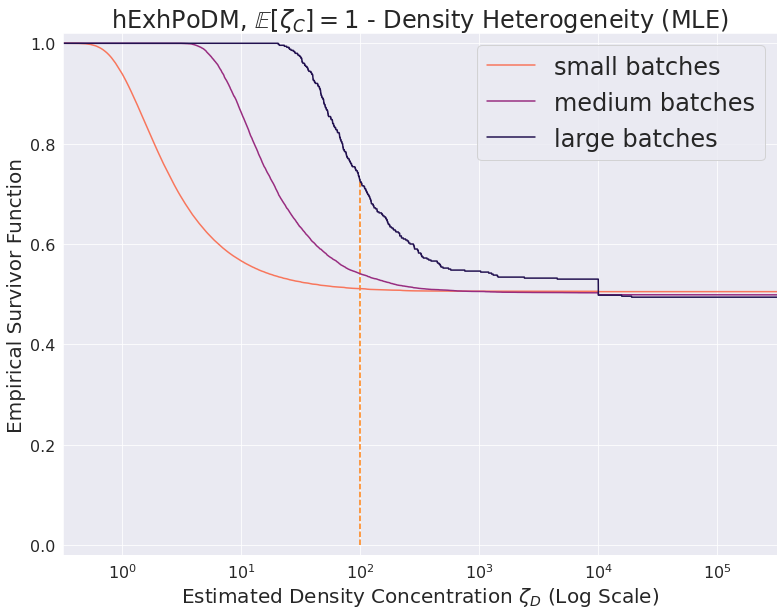

In [14]:
with sns.axes_style("darkgrid"):
    plt.figure(figsize=(12.8,9.6))
    xvals = np.logspace(start=-0.5, stop=5.5, num=10000)
    axis = sns.lineplot(x=np.log(xvals)/np.log(10), y=1.-small_ecdf(xvals), color=magma(4))
    sns.lineplot(x=np.log(xvals)/np.log(10), y=1.-medium_ecdf(xvals), color=magma(2))
    sns.lineplot(x=np.log(xvals)/np.log(10), y=1. - large_ecdf(xvals), color=magma(0))
    axis.legend(labels=["small batches", "medium batches", "large batches"], fontsize=24)
    axis.set_ylabel('Empirical Survivor Function', fontsize=20)
    axis.set_ylim((-0.02,1.02))
    plt.stem([2], [1.-large_ecdf(100)], markerfmt='', linefmt='C1--')
    axis.set_xlim((-0.5,5.5))
    axis.set_xlabel('Estimated Density Concentration $\zeta_D$ (Log Scale)', fontsize=20)
    axis.tick_params(labelsize=16)
    title = 'hExhPoDM, $\mathbb{E}[\zeta_C]=1$ - Density Heterogeneity (MLE)'
    plt.title(title, fontsize=24)
    axis.xaxis.set_major_formatter(mtick.FuncFormatter(x_fmt))
    cool_savefig(title + ' survival')

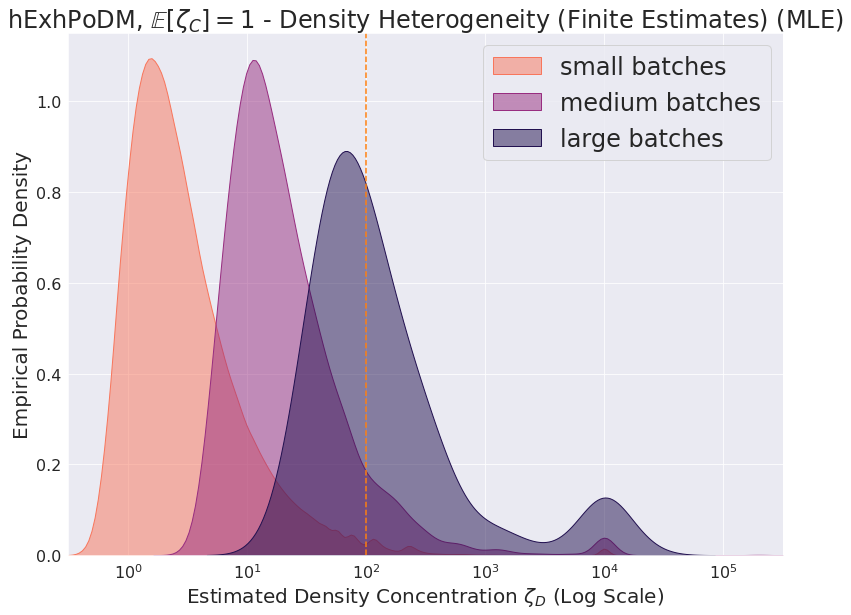

In [15]:
with sns.axes_style("darkgrid"):
    plt.figure(figsize=(12.8, 9.6))
    axis = sns.kdeplot(np.log(finite_part(small_batches_densities))/np.log(10), color=magma(4), fill=True, alpha=0.5)
    sns.kdeplot(np.log(finite_part(medium_batches_densities))/np.log(10), ax=axis, color=magma(2), fill=True, alpha=0.5)
    sns.kdeplot(np.log(finite_part(large_batches_densities))/np.log(10), ax=axis, color=magma(0), fill=True, alpha=0.5)
    axis.legend(labels=["small batches", "medium batches", "large batches"], fontsize=24)
    axis.xaxis.set_major_formatter(mtick.FuncFormatter(x_fmt))
    axis.set_ylabel('Empirical Probability Density', fontsize=20)
    axis.set_xlabel('Estimated Density Concentration $\zeta_D$ (Log Scale)', fontsize=20)
    axis.tick_params(labelsize=16)
    axis.set_xlim((-0.5,5.5))
    axis.set_ylim((0,1.15))
    plt.stem([2], [1.2], markerfmt='', linefmt='C1--')
    title = 'hExhPoDM, $\mathbb{E}[\zeta_C]=1$ - Density Heterogeneity (Finite Estimates) (MLE)'
    plt.title(title, fontsize=24)
    cool_savefig(title + ' kde')

## compared with plugin

In [16]:
small_batches_alt = np.zeros((1500*500))
medium_batches_alt = np.zeros((30*500))
large_batches_alt = np.zeros((500))

In [17]:
filenames = sorted(list(glob('concentration_estimates/*.npz')))

for sim_num in range(500):
    npzfile = np.load(filenames[sim_num])
    
    small_batches_alt[sim_num*1500:(sim_num+1)*1500] = npzfile['small_batches'][0,:]
    medium_batches_alt[sim_num*30:(sim_num+1)*30] = npzfile['medium_batches'][0,:]
    large_batches_alt[sim_num] = npzfile['whole_sim'][0]

In [18]:
np.mean((finite_part(large_batches_densities) - finite_part(large_batches_alt))**2)

5485355.772934367

In [19]:
np.median((finite_part(large_batches_densities) - finite_part(large_batches_alt))**2)

0.0003090532799474609

In [20]:
np.mean((finite_part(medium_batches_densities) - finite_part(medium_batches_alt))**2)

624079.6370329866

In [21]:
np.median((finite_part(medium_batches_densities) - finite_part(medium_batches_alt))**2)

0.00029135251200478225

In [22]:
np.mean((finite_part(small_batches_densities) - finite_part(small_batches_alt))**2)

117296.43684102003

In [23]:
np.median((finite_part(small_batches_densities) - finite_part(small_batches_alt))**2)

0.0003216865056018509